# Проект Дашборд конверсий

### подключаем библиотеки

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from dotenv import load_dotenv
import os

### получаем данные

In [2]:
load_dotenv()

# Получаем значения переменных окружения
API_URL = os.getenv('API_URL')
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')

# Формируем URL для запросов
url_visits = f'{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}'
url_registrations = f'{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}'

# Выполняем запросы
response_visits = requests.get(url_visits)
data_visits = response_visits.json()

response_registrations = requests.get(url_registrations)
data_registrations = response_registrations.json()

### изучаем данные

In [3]:
df_visits = pd.DataFrame(data_visits)
df_visits.head(10)

,visit_id,platform,user_agent,datetime
0,1de9ea66-70d3-4a1f-8735-df5ef7697fb9,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01T10:36:22
1,f149f542-e935-4870-9734-6b4501eaf614,web,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,2023-03-01T06:25:00
2,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,2023-03-01T10:26:13
3,19322fed-157c-49c6-b16e-2d5cabeb9592,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,2023-03-01T12:33:06
4,04762a22-3c9f-40c9-9ac9-6628c4381836,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01T01:38:35
5,040e1e30-c9ed-4248-bc97-99a707e36d60,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01T02:11:55
6,7bf78a4d-9f8f-4ffb-a5f8-0a0a58994953,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01T23:43:34
7,175e9941-2607-4d5f-b6ab-14759da618fd,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01T02:50:27
8,d868c2cf-1d4a-4b12-b6a2-0bb02edf0743,web,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,2023-03-01T16:37:35
9,e1668271-7c9b-4fae-80ca-17b703be0e66,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...,2023-03-01T08:28:12


In [4]:
df_visits.tail(10)

,visit_id,platform,user_agent,datetime
263449,c2114102-ebfd-4214-9d81-9e6e2c02bf86,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-08-28T03:32:26
263450,2c708858-25f0-4424-bdb3-a5f014a838b2,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-08-31T04:49:53
263451,c737e953-60bc-4191-8cf3-cbc21a0ccbf0,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-08-29T11:01:36
263452,6d7ccc66-9c92-4b32-b5ff-18a68eabe629,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...,2023-08-30T07:24:04
263453,6d2e2f5b-970b-4dfe-8f57-25711a5b2a5d,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,2023-08-28T04:58:17
263454,6d2e2f5b-970b-4dfe-8f57-25711a5b2a5d,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,2023-08-29T10:43:29
263455,1d91535e-d984-4f76-bbaa-c14c0fd4f2e2,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-08-29T19:29:16
263456,f2496721-7126-430d-976e-777a6cdccb4f,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-08-29T12:51:11
263457,f2496721-7126-430d-976e-777a6cdccb4f,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-08-29T21:45:08
263458,73047125-de44-4d65-8229-7218acff4ddc,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-08-30T19:19:04


In [5]:
df_registrations = pd.DataFrame(data_registrations)
df_registrations.head(10)

,datetime,user_id,email,platform,registration_type
0,2023-03-01T07:40:13,2e0f6bb8-b029-4f45-a786-2b53990d37f1,ebyrd@example.org,web,google
1,2023-03-01T13:14:00,f007f97c-9d8b-48b5-af08-119bb8f6d9b6,knightgerald@example.org,web,email
2,2023-03-01T03:05:50,24ff46ae-32b3-4a74-8f27-7cf0b8f32f15,cherylthompson@example.com,web,apple
3,2023-03-01T00:04:47,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,halldavid@example.org,web,email
4,2023-03-01T18:31:52,27f875fc-f8ce-4aeb-8722-0ecb283d0760,denise86@example.net,web,google
5,2023-03-01T03:54:43,9a918a05-768e-49f5-ae48-183618bdeb7b,wrightmelissa@example.com,web,apple
6,2023-03-01T20:52:05,84ffb27c-d8a4-4cdf-a2a3-635fb3f8a170,wallaceandrew@example.org,web,email
7,2023-03-01T06:12:27,380a8791-323a-4ba8-936a-5616ae39220f,wrightrobert@example.org,web,email
8,2023-03-01T16:31:44,f65902f0-97b9-4817-9457-dfd41284ee50,nmartin@example.com,android,email
9,2023-03-01T05:47:06,64a4acc1-f2c7-4de6-8b27-ae9b68ff0b29,edward70@example.net,android,email


In [6]:
df_registrations.tail(10)

,datetime,user_id,email,platform,registration_type
21826,2023-08-31T03:18:54,19e09209-ba96-4e4a-bc79-f1eff1c5a603,benjaminnoble@example.com,ios,email
21827,2023-08-31T16:18:35,9ab1350a-9381-43a2-a049-49b983530906,xleonard@example.net,ios,apple
21828,2023-08-31T12:59:21,99583e52-8c92-4219-bf07-7165dd4125bb,melissaharris@example.org,ios,email
21829,2023-08-31T07:05:30,66c932d7-438a-437c-840b-006bb3a37bb6,michaelkemp@example.org,ios,email
21830,2023-08-31T20:47:33,140eb03e-84a4-45ab-928e-7fff76a49b0a,ohart@example.org,ios,apple
21831,2023-08-31T07:32:08,a94b4a28-f25c-433c-b4ef-85af7d5b0c11,ikelley@example.net,ios,apple
21832,2023-08-31T23:25:50,fc709c6b-528b-40d8-8980-c2c278e5a628,brittanycox@example.net,ios,apple
21833,2023-08-31T19:29:18,11e32805-7571-4108-8e50-e211d051bf7e,aryan@example.net,ios,apple
21834,2023-08-31T19:38:54,bce7b818-768b-434a-b6af-573cd60bff7f,emartinez@example.net,ios,email
21835,2023-08-31T08:36:05,fe03e08a-8e86-4b5f-9a50-c18a02b0d234,terriperry@example.net,ios,email


### краткая сводка по данным

In [7]:
df_visits.describe()

,visit_id,platform,user_agent,datetime
count,263459,263459,263459,263459
unique,146085,4,32,261204
top,64167edd-323a-4ab0-be9b-acd237a1ac30,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-07-06T10:45:50
freq,4,236301,13623,3


In [8]:
df_registrations.describe()

,datetime,user_id,email,platform,registration_type
count,21836,21836,21836,21836,21836
unique,21821,21836,20868,3,4
top,2023-06-23T13:10:45,2e0f6bb8-b029-4f45-a786-2b53990d37f1,ujones@example.com,android,email
freq,2,1,6,10582,8996


### Создание каталога

In [9]:
chart_path = './charts'
if not os.path.exists(chart_path):
    os.makedirs(chart_path)

### Расчет метрик

In [10]:
# Преобразуем datetime в формат даты (без времени)
df_visits['date'] = pd.to_datetime(df_visits['datetime']).dt.date
df_registrations['date'] = pd.to_datetime(df_registrations['datetime']).dt.date

# Убираем визиты, которые были сделаны ботами
df_visits = df_visits[~df_visits['user_agent'].str.contains('bot')]

# Сгруппируем данные по дате и платформам для визитов
df_visits = df_visits.sort_values(by=['visit_id', 'date']).drop_duplicates(subset=['visit_id'], keep='last')
visits_grouped = df_visits.groupby(['date', 'platform']).size().reset_index(name='visits')

# Сгруппируем данные регистраций по дате и платформам
registrations_grouped = (df_registrations
                         .groupby(['date', 'platform'])
                         .agg(registrations=('user_id', 'count'))
                         .reset_index())

# Объединяем датафреймы визитов и регистраций
merged_df = pd.merge(visits_grouped, registrations_grouped, on=['date', 'platform'], how='outer').fillna(0)

# Рассчитаем конверсию
merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits'].replace(0, np.nan)) * 100

# Приводим датафрейм в нужный формат
merged_df['date_group'] = merged_df['date']
final_df = merged_df[['date_group', 'platform', 'visits', 'registrations', 'conversion']]

# Сортируем данные по дате
final_df = final_df.sort_values(by='date_group')

# Сохраняем датафрейм в формате JSON
final_df.to_json('./conversion.json')

In [11]:
final_df.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355


In [12]:
final_df.tail(20)

,date_group,platform,visits,registrations,conversion
532,2023-08-25,ios,36,25,69.444444
533,2023-08-25,web,882,62,7.029478
534,2023-08-26,android,147,114,77.551020
535,2023-08-26,ios,60,41,68.333333
536,2023-08-26,web,759,30,3.952569
538,2023-08-27,ios,24,18,75.000000
537,2023-08-27,android,56,39,69.642857
539,2023-08-27,web,715,31,4.335664
541,2023-08-28,ios,35,23,65.714286
540,2023-08-28,android,44,34,77.272727


### добавляем рекламу

In [13]:
# Загрузка данных о рекламных кампаниях
ads_df = pd.read_csv('ads.csv')

In [14]:
ads_df['date'] = pd.to_datetime(ads_df['date']).dt.date

# Сагрегируем данные по дате и utm_campaign, суммируем затраты
ads_grouped = (ads_df
               .groupby(['date', 'utm_campaign'])
               .agg(cost=('cost', 'sum'))
               .reset_index())

# Агрегируем по дате
ads_grouped = (ads_grouped
               .groupby('date')
               .agg(cost=('cost', 'sum'),
                    utm_campaign=('utm_campaign', lambda x: ', '.join(x) if not x.empty else 'none'))
               .reset_index())

# Переименуем 'date' в 'date_group'
ads_grouped.rename(columns={'date': 'date_group'}, inplace=True)

# Объединяем датафрейм с конверсиями
final_df['date_group'] = pd.to_datetime(final_df['date_group']).dt.date
merged_final = pd.merge(final_df.groupby('date_group').agg(
                          visits=('visits', 'sum'),
                          registrations=('registrations', 'sum')).reset_index(), 
                        ads_grouped, 
                        on='date_group', 
                        how='left')

# Заполняем отсутствующие значения
merged_final['utm_campaign'] = merged_final['utm_campaign'].fillna('none')
merged_final['cost'] = merged_final['cost'].fillna(0)

# Оставляем нужные колонки в итоговом датафрейме
final_result = merged_final[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]

# Сортируем данные по date_group
final_result = final_result.sort_values(by='date_group')

# Сохраняем итоговый датафрейм в формате JSON
final_result.to_json('./ads.json')

In [15]:
final_result.head(10)

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,376,87,212.0,advanced_algorithms_series
1,2023-03-02,613,106,252.0,advanced_algorithms_series
2,2023-03-03,683,107,202.0,advanced_algorithms_series
3,2023-03-04,647,159,223.0,advanced_algorithms_series
4,2023-03-05,707,115,265.0,advanced_algorithms_series
5,2023-03-06,1291,230,108.0,advanced_algorithms_series
6,2023-03-07,1382,124,165.0,advanced_algorithms_series
7,2023-03-08,1382,151,155.0,advanced_algorithms_series
8,2023-03-09,1064,209,124.0,advanced_algorithms_series
9,2023-03-10,812,112,276.0,advanced_algorithms_series


In [16]:
final_result.tail(20)

,date_group,visits,registrations,cost,utm_campaign
164,2023-08-12,630,149,120.0,intro_to_python_course
165,2023-08-13,834,92,250.0,intro_to_python_course
166,2023-08-14,801,140,297.0,intro_to_python_course
167,2023-08-15,1136,159,276.0,intro_to_python_course
168,2023-08-16,471,75,108.0,intro_to_python_course
169,2023-08-17,922,129,271.0,intro_to_python_course
170,2023-08-18,1014,105,169.0,intro_to_python_course
171,2023-08-19,1159,110,196.0,intro_to_python_course
172,2023-08-20,612,87,272.0,intro_to_python_course
173,2023-08-21,1094,140,137.0,intro_to_python_course


## Визуализация

### Итоговые визиты

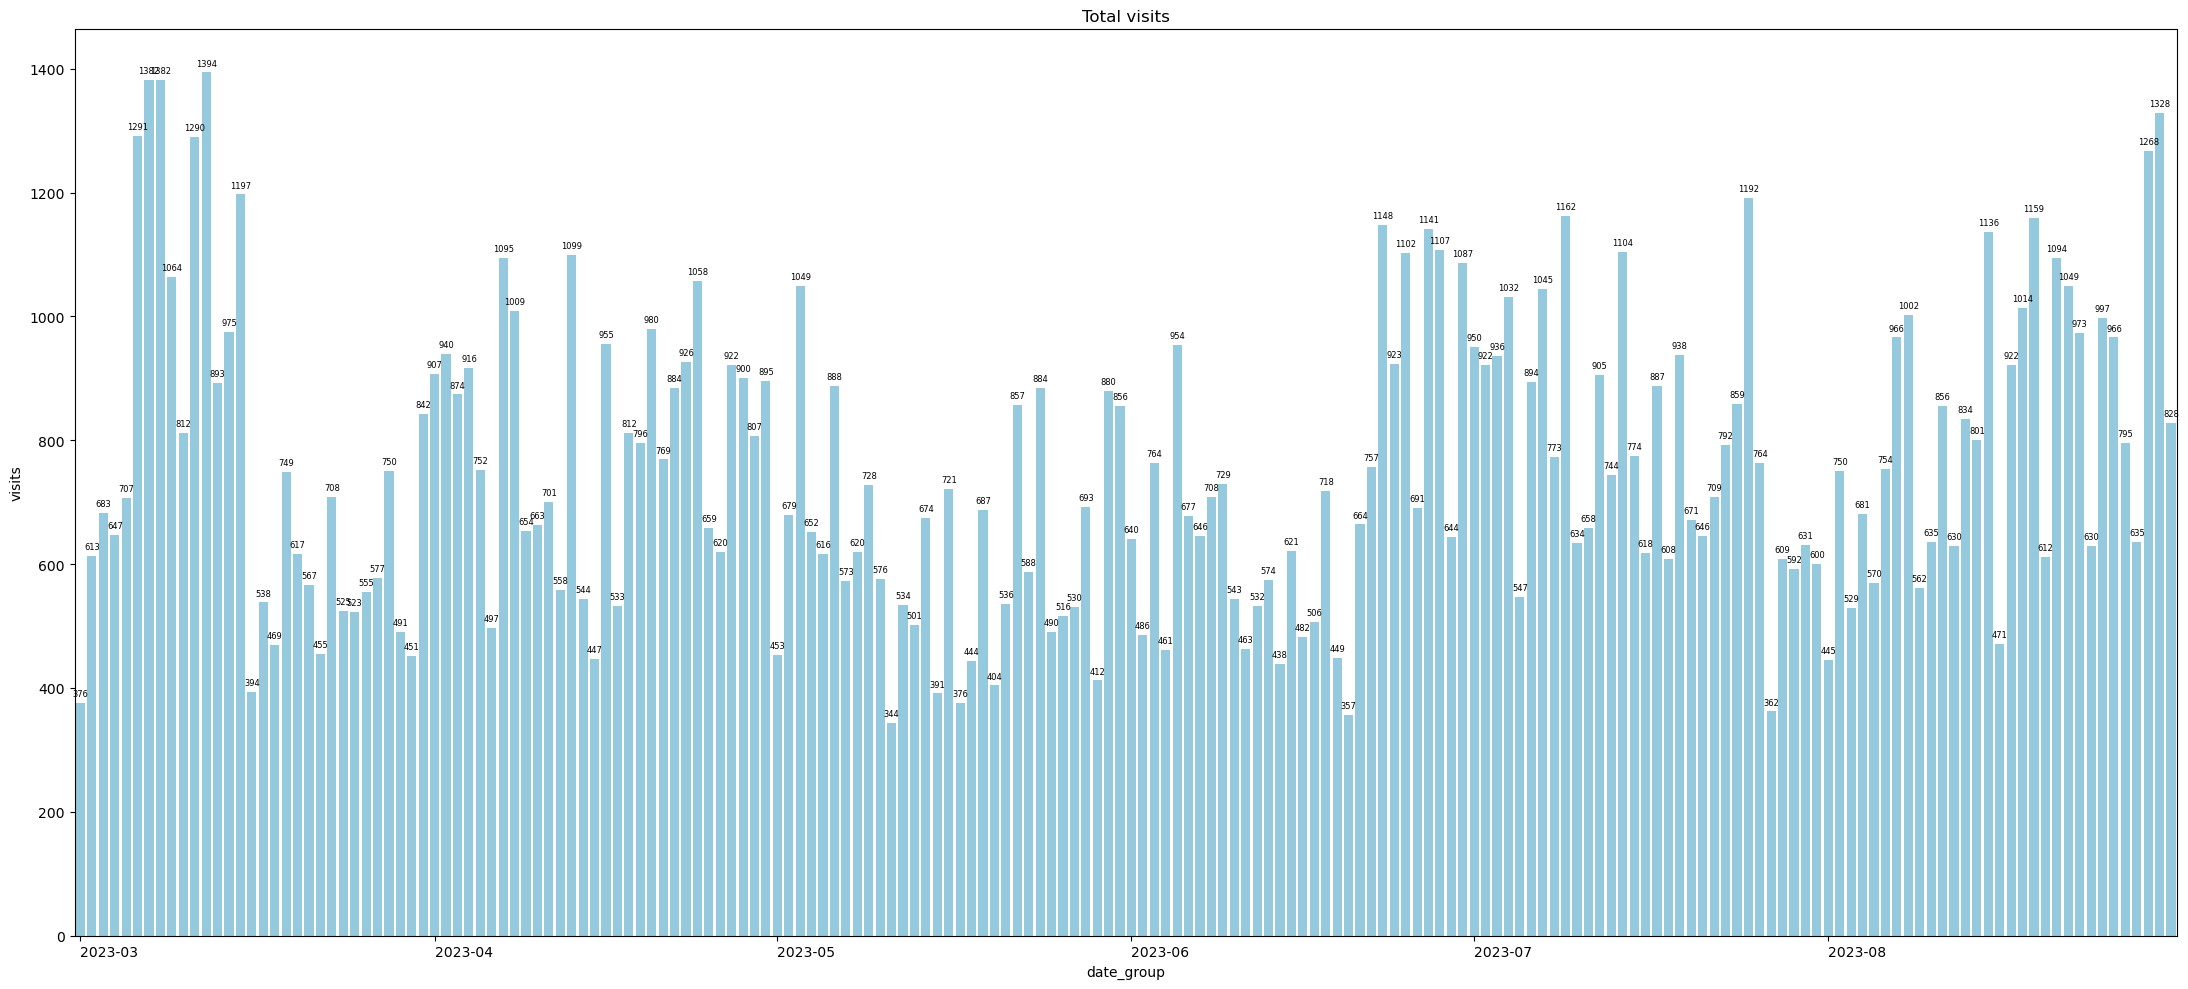

In [17]:
plt.figure(figsize=(22, 10))
bar_plot = sns.barplot(data=final_result, x='date_group', y='visits', color='skyblue')
plt.title('Total visits')
plt.xlabel('date_group')
plt.ylabel('visits')
final_result['date_group'] = pd.to_datetime(final_result['date_group'])
monthly_ticks = final_result[final_result['date_group'].dt.is_month_start]
monthly_ticks_positions = monthly_ticks.index
plt.xticks(monthly_ticks_positions, labels=monthly_ticks['date_group'].dt.strftime('%Y-%m'), rotation=0, ha='left')
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='baseline', color='black', fontsize=6, xytext=(0, 5),
                        textcoords='offset points')
    
plt.tight_layout()
plt.savefig(f'./charts/total_visits')
plt.show()

### Итоговые визиты с разбивкой по платформам

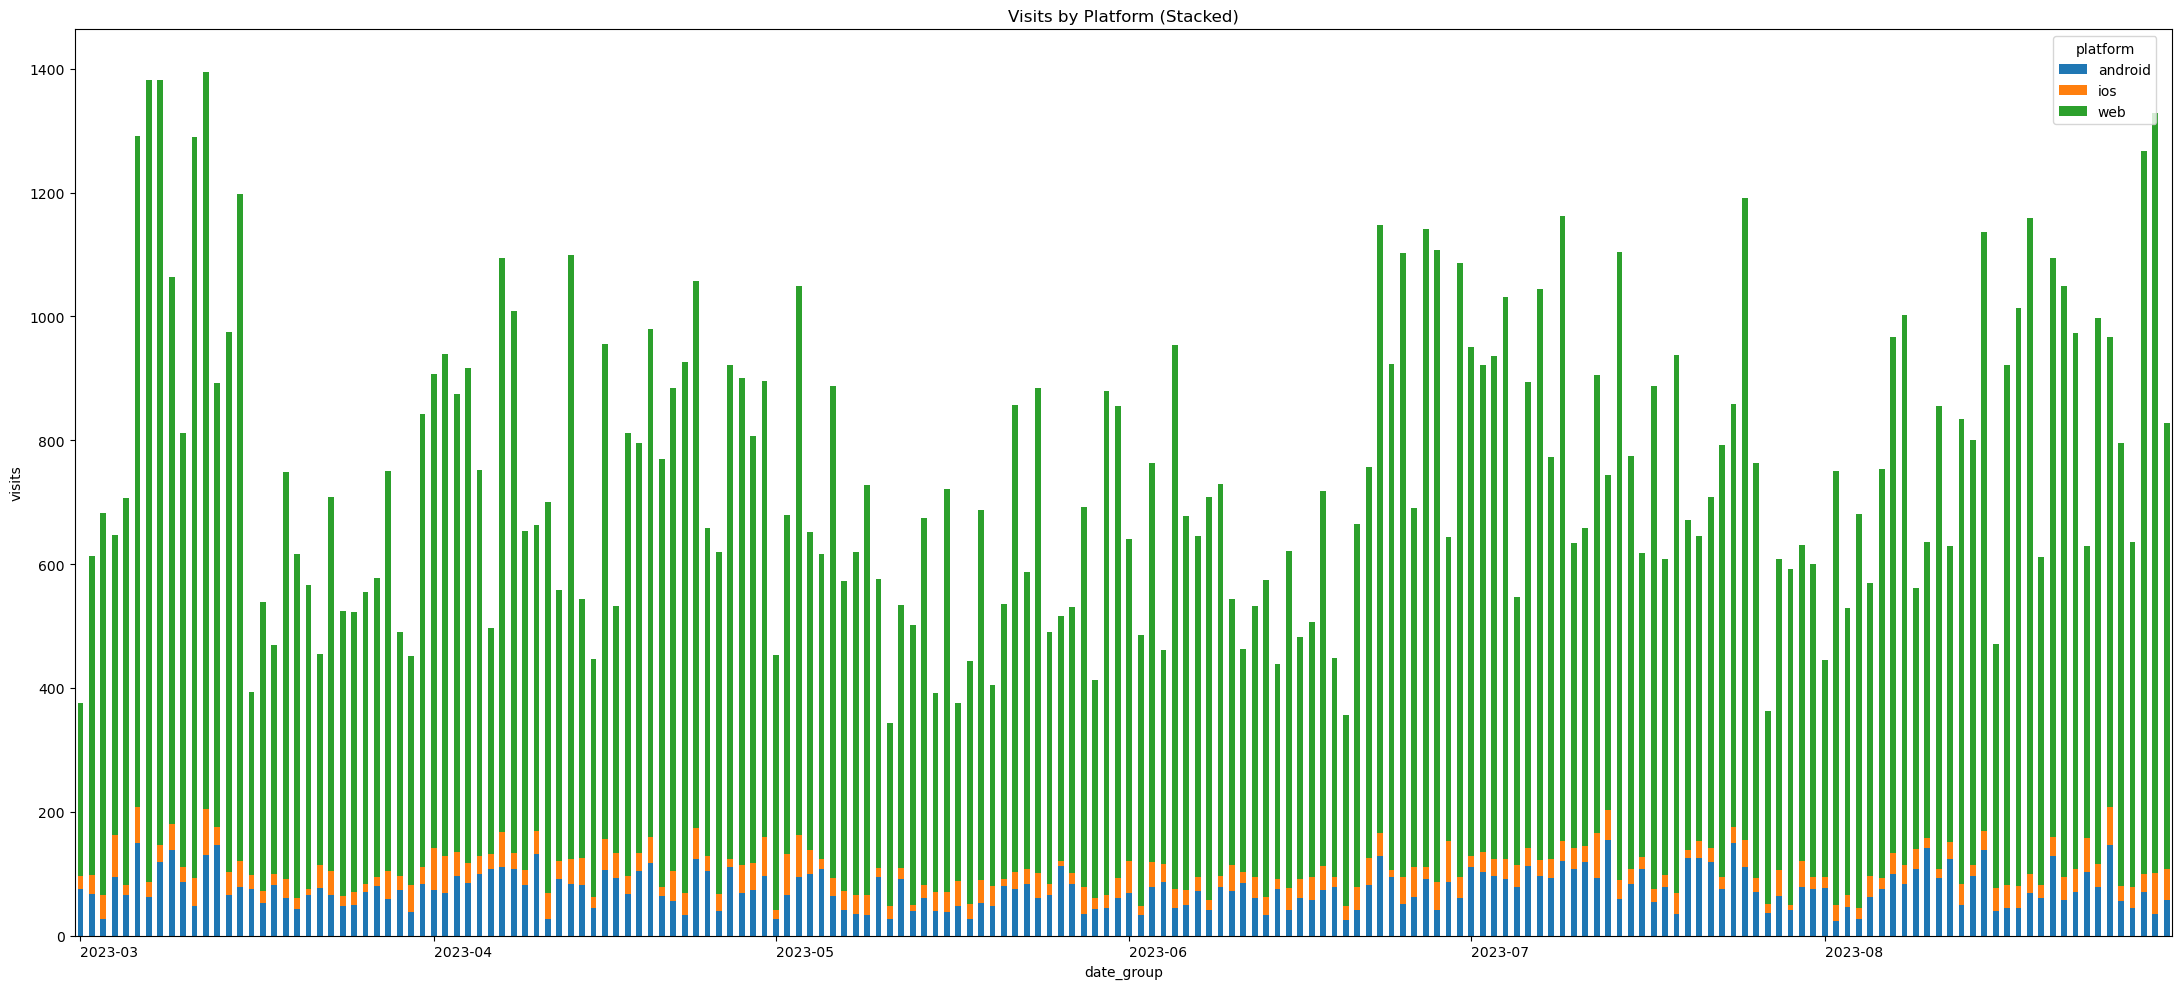

In [18]:
final_df['date_group'] = pd.to_datetime(final_df['date_group'])

# Сгруппируем данные по дате и платформам
stacked_data = final_df.pivot_table(index='date_group', columns='platform', values='visits', fill_value=0)

# Построим stacked bar chart
plt.figure(figsize=(22, 10))
stacked_data.plot(kind='bar', stacked=True, ax=plt.gca())

# Настраиваем заголовки оси
plt.title('Visits by Platform (Stacked)')
plt.xlabel('date_group')
plt.ylabel('visits')

monthly_ticks = stacked_data.index[stacked_data.index.day == 1]  # Только первые дни месяца
monthly_tick_positions = [stacked_data.index.get_loc(date) for date in monthly_ticks]
plt.xticks(monthly_tick_positions, labels=monthly_ticks.strftime('%Y-%m'), rotation=0, ha='left')

# Добавляем легенду
plt.legend(title='platform', bbox_to_anchor=(0.94, 1), loc='upper left')

plt.tight_layout()
plt.savefig('./charts/total_visits_by_platform.png')
plt.show()

### Итоговые регистрации

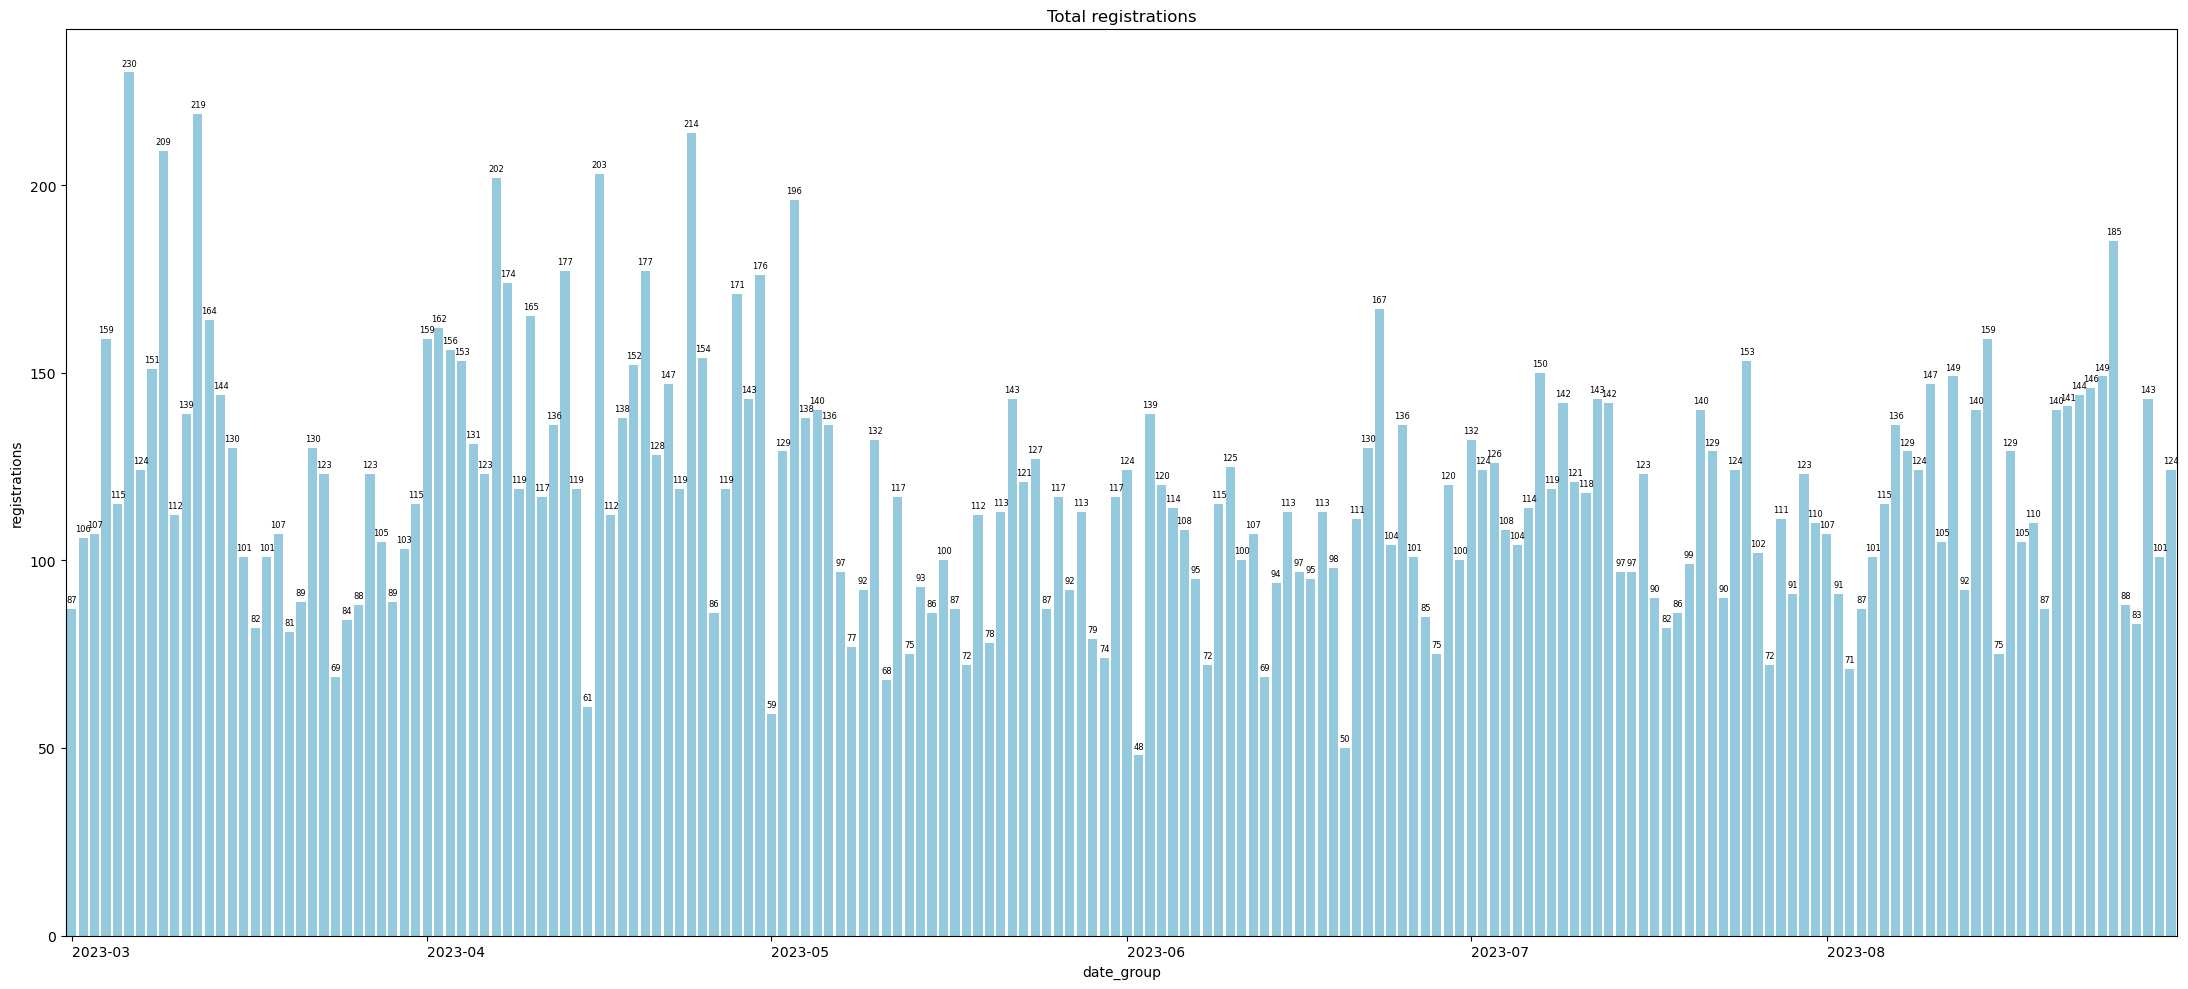

In [19]:
plt.figure(figsize=(22, 10))
bar_plot = sns.barplot(data=final_result, x='date_group', y='registrations', color='skyblue')
plt.title('Total registrations')
plt.xlabel('date_group')
plt.ylabel('registrations')
final_result['date_group'] = pd.to_datetime(final_result['date_group'])
monthly_ticks = final_result[final_result['date_group'].dt.is_month_start]
monthly_ticks_positions = monthly_ticks.index
plt.xticks(monthly_ticks_positions, labels=monthly_ticks['date_group'].dt.strftime('%Y-%m'), rotation=0, ha='left')
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='baseline', color='black', fontsize=6, xytext=(0, 5),
                        textcoords='offset points')
    
plt.tight_layout()
plt.savefig(f'./charts/total_registrations')
plt.show()

### Итоговые регистрации с разбивкой по платформе

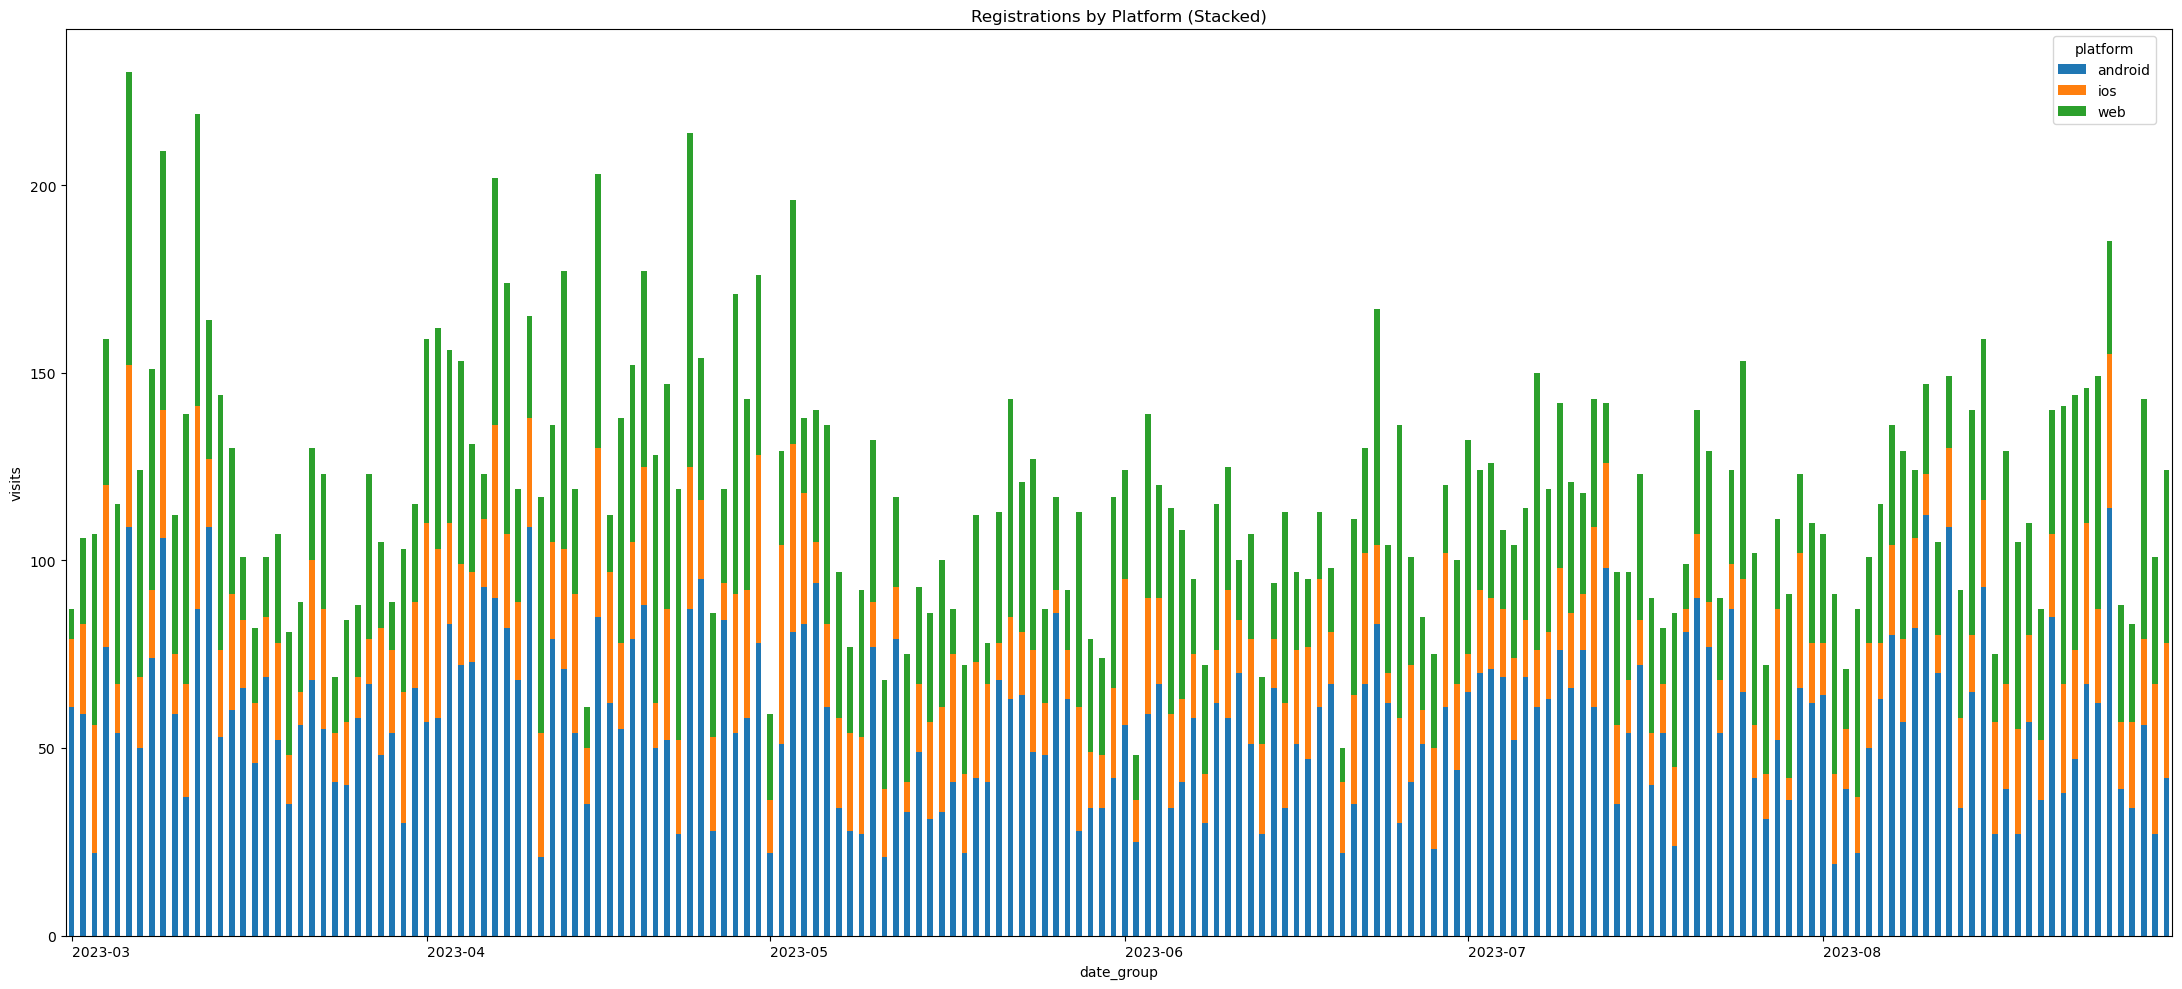

In [20]:
final_df['date_group'] = pd.to_datetime(final_df['date_group'])

# Сгруппируем данные по дате и платформам
stacked_data = final_df.pivot_table(index='date_group', columns='platform', values='registrations', fill_value=0)

# Построим stacked bar chart
plt.figure(figsize=(22, 10))
stacked_data.plot(kind='bar', stacked=True, ax=plt.gca())

# Настраиваем заголовки оси
plt.title('Registrations by Platform (Stacked)')
plt.xlabel('date_group')
plt.ylabel('visits')

monthly_ticks = stacked_data.index[stacked_data.index.day == 1]  # Только первые дни месяца
monthly_tick_positions = [stacked_data.index.get_loc(date) for date in monthly_ticks]
plt.xticks(monthly_tick_positions, labels=monthly_ticks.strftime('%Y-%m'), rotation=0, ha='left')

# Добавляем легенду
plt.legend(title='platform', bbox_to_anchor=(0.94, 1), loc='upper left')

plt.tight_layout()
plt.savefig('./charts/total_registrations_by_platform.png')
plt.show()

### Общая конверсия

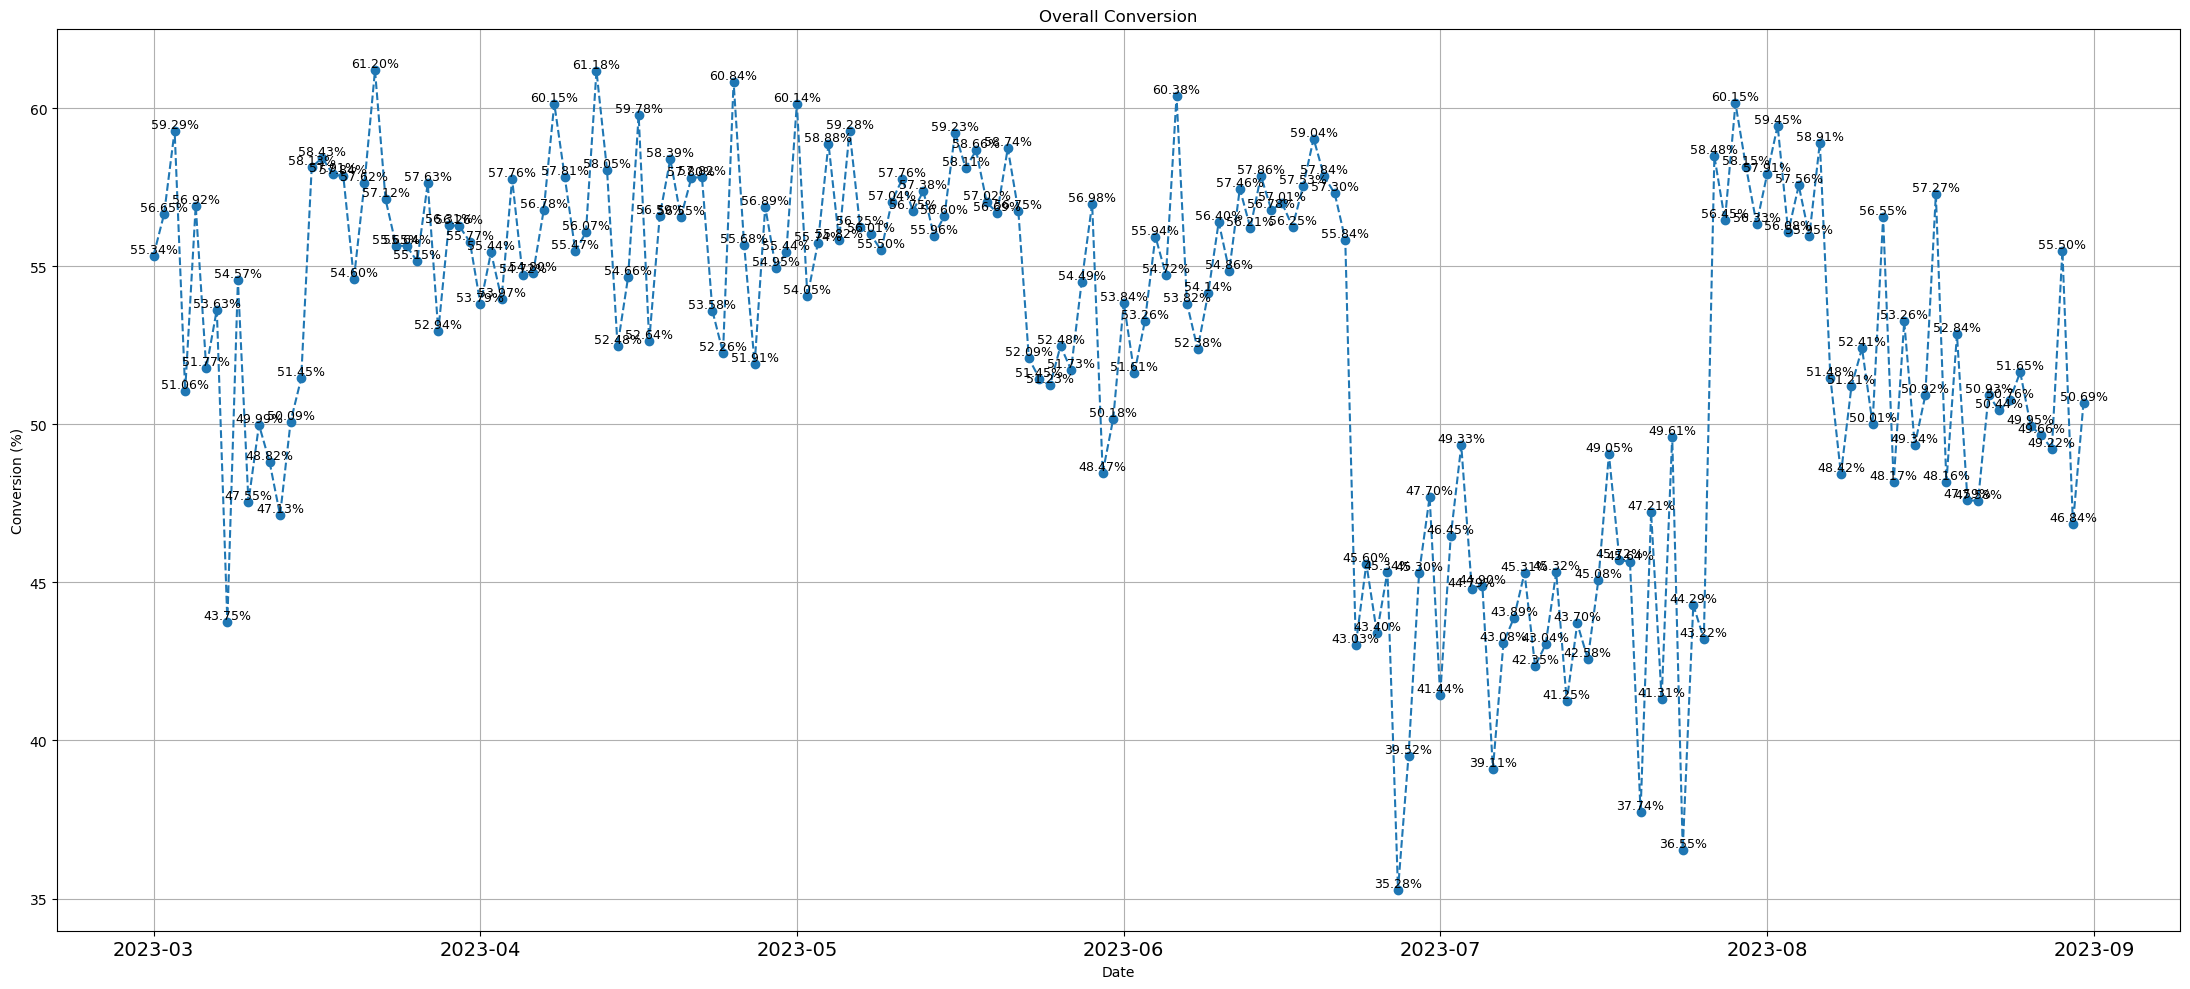

In [21]:
final_df['date_group'] = pd.to_datetime(final_df['date_group'])

conversion_data = final_df.groupby('date_group')['conversion'].mean().reset_index()

# Настраиваем график
plt.figure(figsize=(22, 10))
plt.plot(conversion_data['date_group'], conversion_data['conversion'], marker='o', linestyle='dashed')

# Добавляем подписанные значения на график
for idx, row in conversion_data.iterrows():
    plt.text(row['date_group'], row['conversion'], f"{row['conversion']:.2f}%", 
             ha='center', va='bottom', fontsize=9)

# Настроим заголовки и метки
plt.title('Overall Conversion')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.xticks(fontsize=14)
plt.grid()

# Сохраняем и показываем график
plt.tight_layout()
plt.savefig('./charts/overall_conversiont.png')
plt.show()

### конверсии для каждой платформы

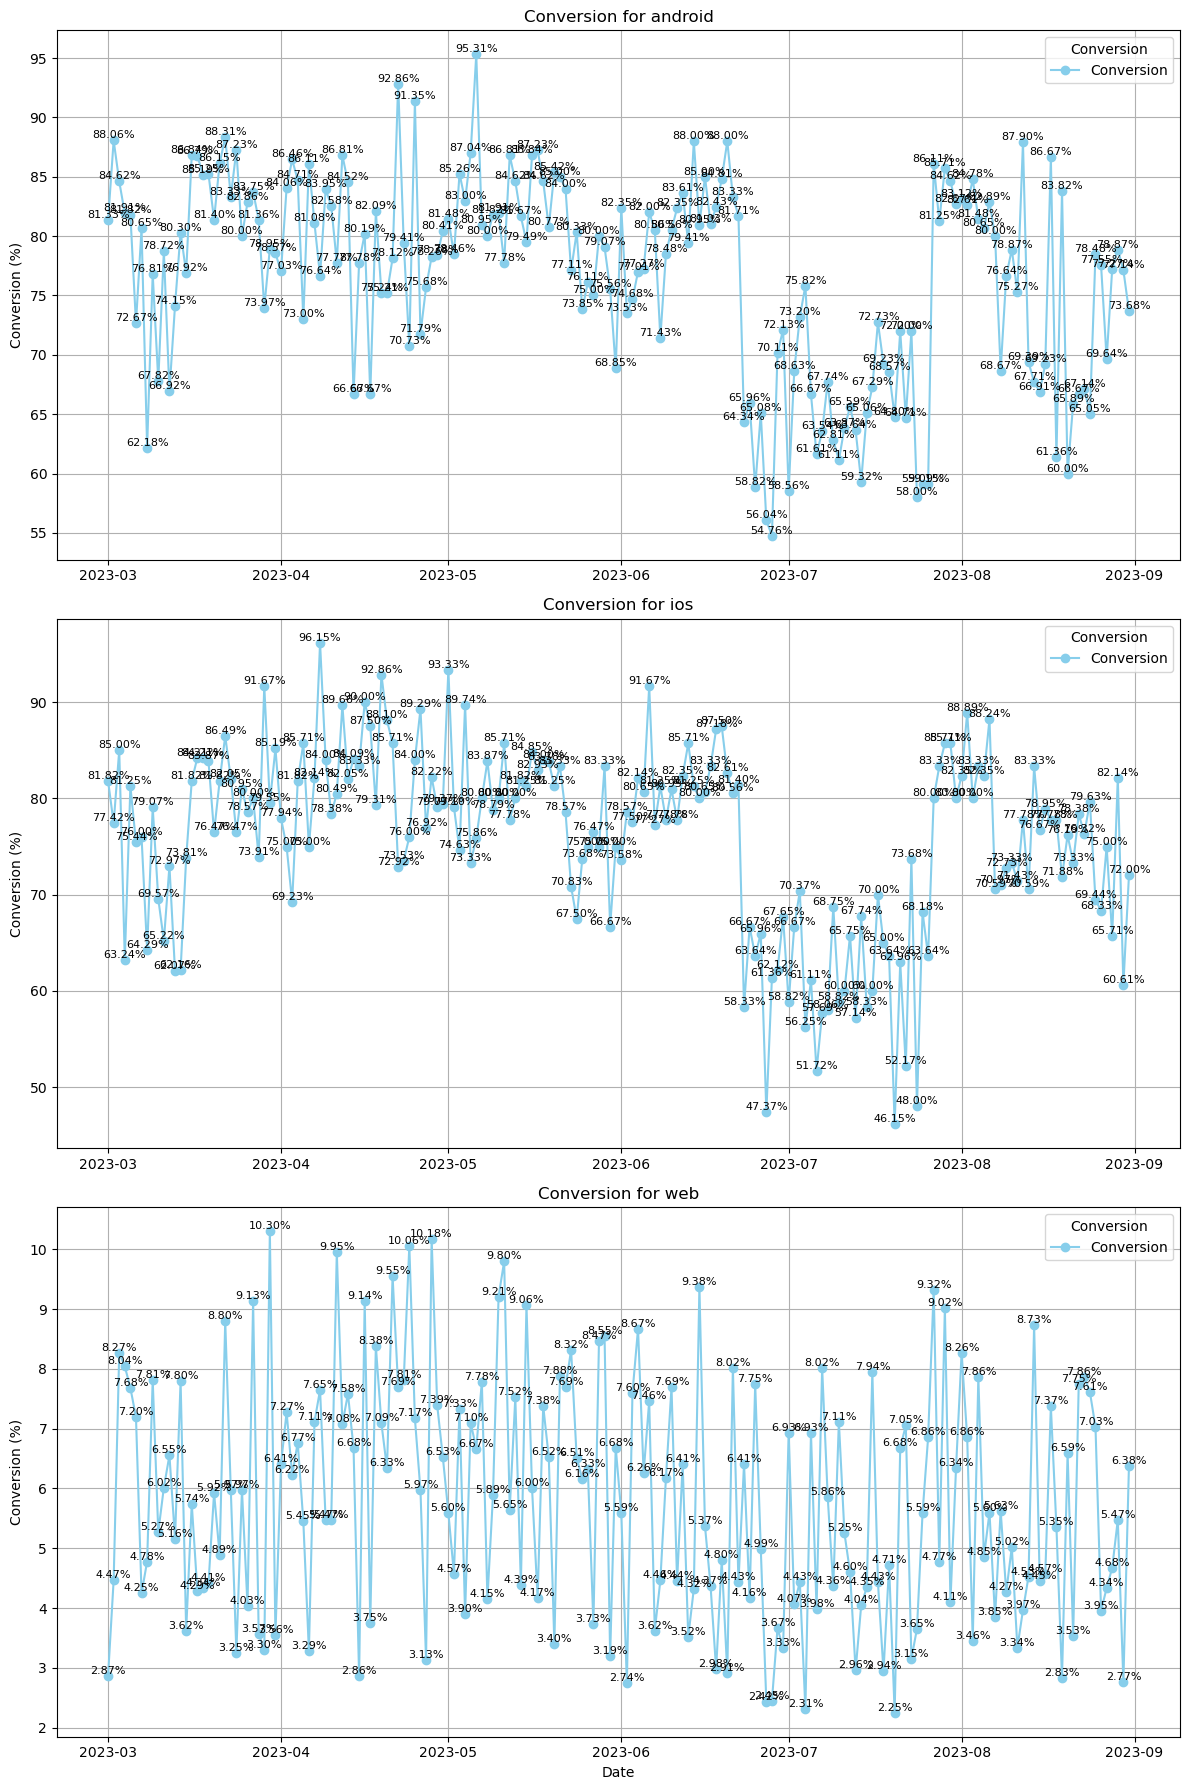

In [22]:
final_df['date_group'] = pd.to_datetime(final_df['date_group'])

# Создаем сводную таблицу для получения итоговых конверсий по дням для каждой платформы
conversion_data = final_df.groupby(['date_group', 'platform'])['conversion'].mean().reset_index()

platforms = conversion_data['platform'].unique()

# Настраиваем графики
fig, axs = plt.subplots(len(platforms), 1, figsize=(12, 18))

for i, platform in enumerate(platforms):
    platform_data = conversion_data[conversion_data['platform'] == platform]
    axs[i].plot(platform_data['date_group'], platform_data['conversion'], marker='o', color='skyblue', label='Conversion')

    # Добавляем подписанные значения на график
    for idx, row in platform_data.iterrows():
        axs[i].text(row['date_group'], row['conversion'], f"{row['conversion']:.2f}%", 
                    ha='center', va='bottom', fontsize=8)

    # Настроим заголовки и метки для каждого графика
    axs[i].set_title(f'Conversion for {platform}')
    axs[i].set_ylabel('Conversion (%)')
    axs[i].grid()
    axs[i].legend(title='Conversion')

# Настройка оси X
plt.xlabel('Date')

plt.tight_layout()
plt.savefig('./charts/conversion_by_platforms.png')
plt.show()

### стоимости рекламы

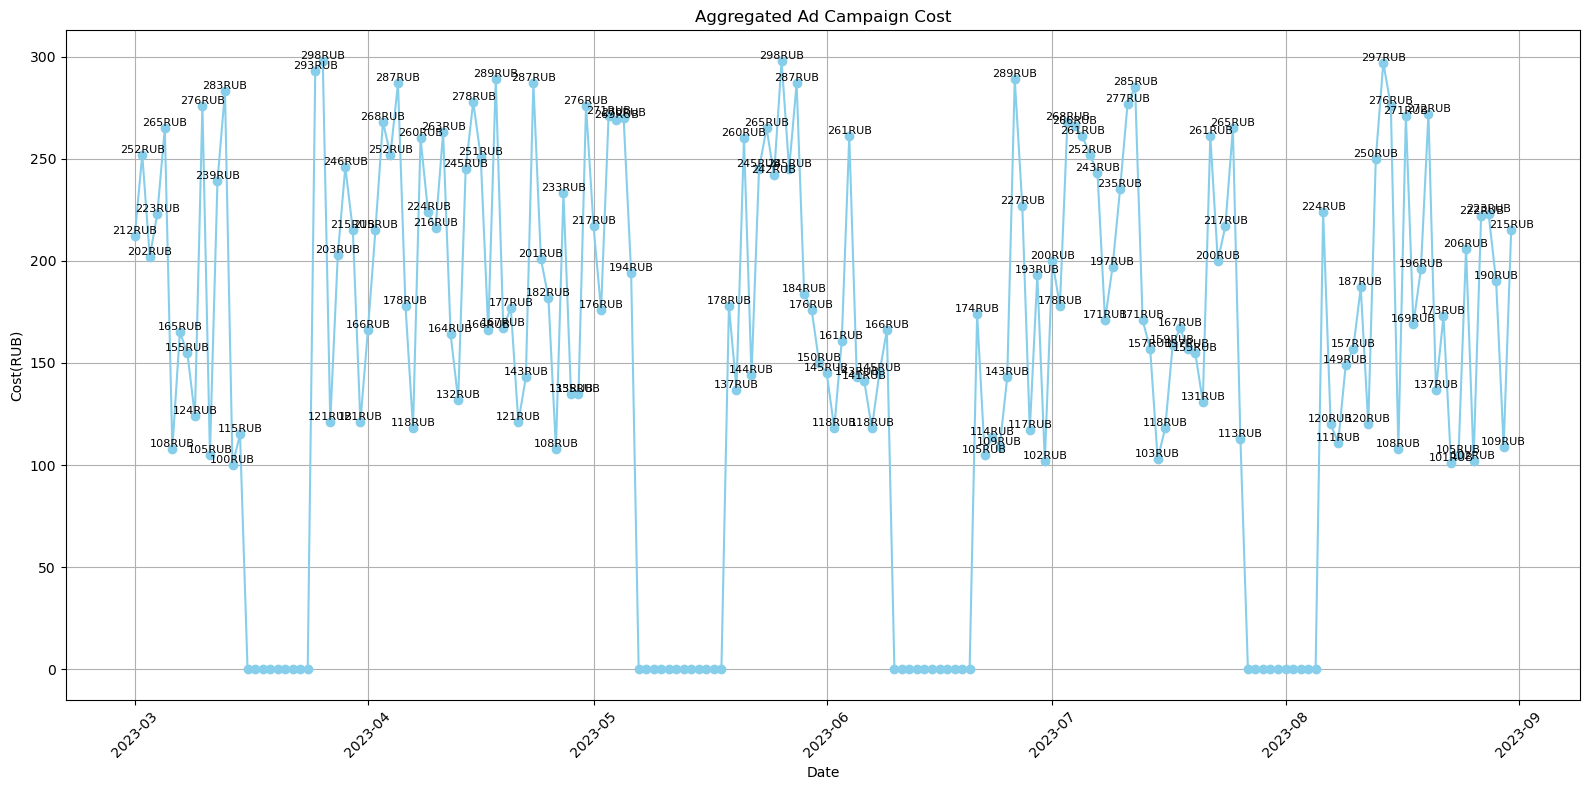

In [23]:
final_result['date_group'] = pd.to_datetime(final_result['date_group'])

# Настройка графика
plt.figure(figsize=(16, 8))
plt.plot(final_result['date_group'], final_result['cost'], marker='o', linestyle='-', color='skyblue')

for idx, row in final_result.iterrows():
    if row['cost'] == 0:
            continue
    plt.text(row['date_group'], row['cost'], f"{row['cost']:.0f}RUB", 
             ha='center', va='bottom', fontsize=8)

# Добавление подписей и заголовка
plt.title('Aggregated Ad Campaign Cost')
plt.xlabel('Date')
plt.ylabel('Cost(RUB)')
plt.xticks(rotation=45)  # Поворот меток оси X для удобства чтения
plt.grid()
plt.tight_layout()

# Сохранение и отображение графика
plt.savefig('./charts/ad_cost.png')
plt.show()

### Визиты за весь период с цветовым выделением рекламной кампании

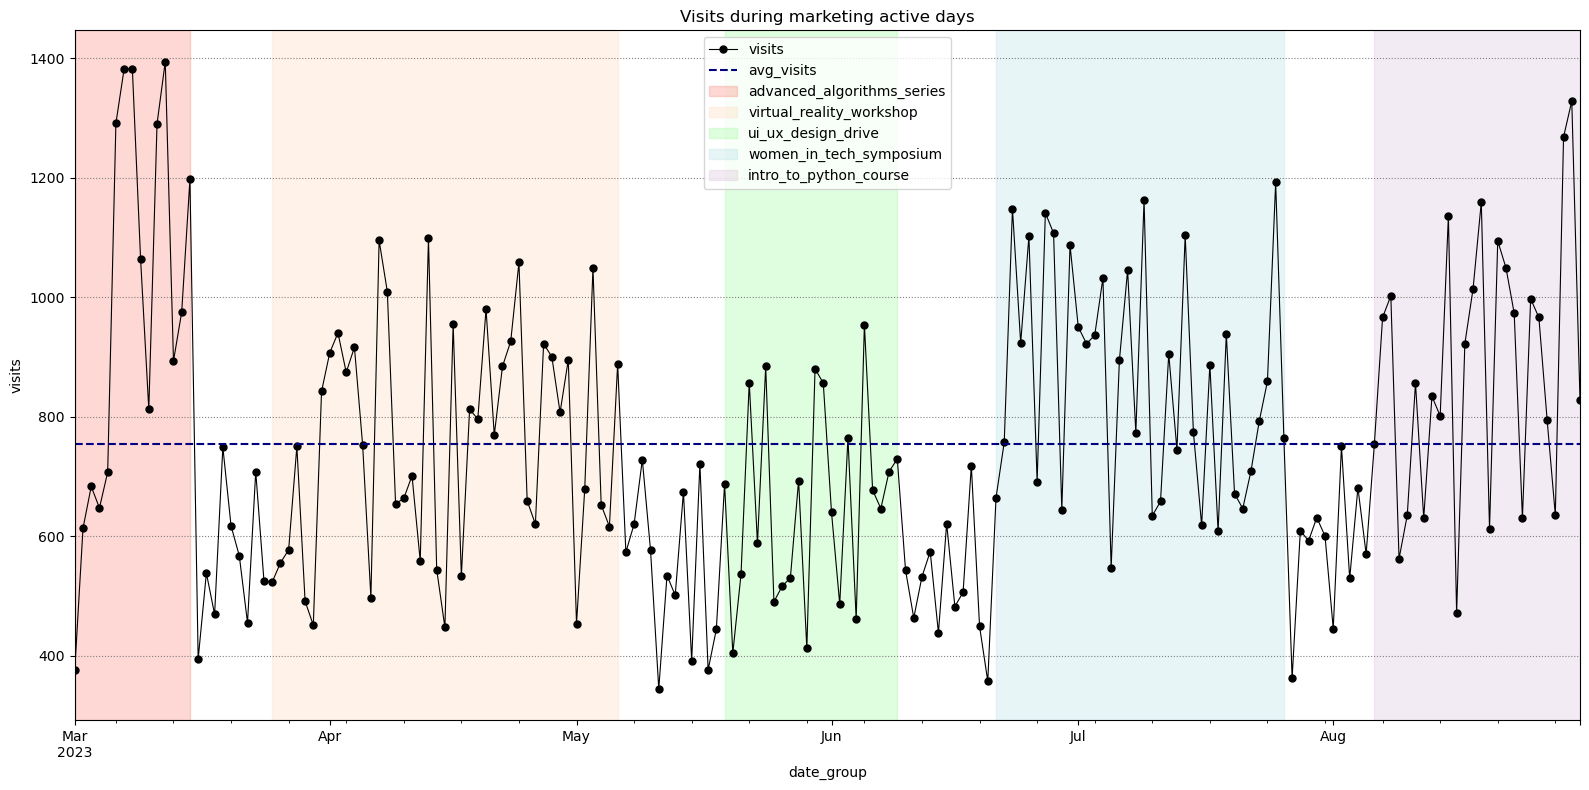

In [24]:
visits_color = final_result.copy()
visits_color['date_group'] = pd.to_datetime(visits_color['date_group'])

# Создаем колонку с номерами кампаний
visits_color['campaigns_n'] = (visits_color['utm_campaign'] != visits_color['utm_campaign'].shift()).cumsum()

# Фильтруем данные, исключая строки с 'none'
campaign_periods = (visits_color
                    .dropna(subset=['utm_campaign'])
                    .loc[visits_color['utm_campaign'] != 'none']  # Исключаем 'none'
                    .groupby(['campaigns_n','utm_campaign'])
                    .agg(start=('date_group', 'min'), finish=('date_group', 'max'))
                    .reset_index()
                   )

# Строим график
visits_color.plot(x='date_group', y='visits', kind='line', figsize=(16, 8), 
                  linewidth=0.8, color='black', label='visits', marker='o', markersize=5)
plt.axhline(visits_color['visits'].mean(), linestyle='--', color='navy', label='avg_visits')

# Добавляем цветные области для каждой рекламной кампании
colors = ['salmon', 'peachpuff', 'palegreen', 'powderblue', 'thistle']
for i, row in campaign_periods.iterrows():
    plt.axvspan(row['start'], row['finish'], color=colors[i % len(colors)], alpha=0.3, label=row['utm_campaign'])

# Оформление графика
plt.grid(axis='y', linestyle=':', color='grey')
plt.legend(loc='best')
plt.title('Visits during marketing active days')
plt.xlabel('date_group')
plt.ylabel('visits')
plt.tight_layout()
plt.savefig('./charts/visits_during_campaigns.png')
plt.show()

### Регистрации за весь период с цветовым выделением рекламной кампании

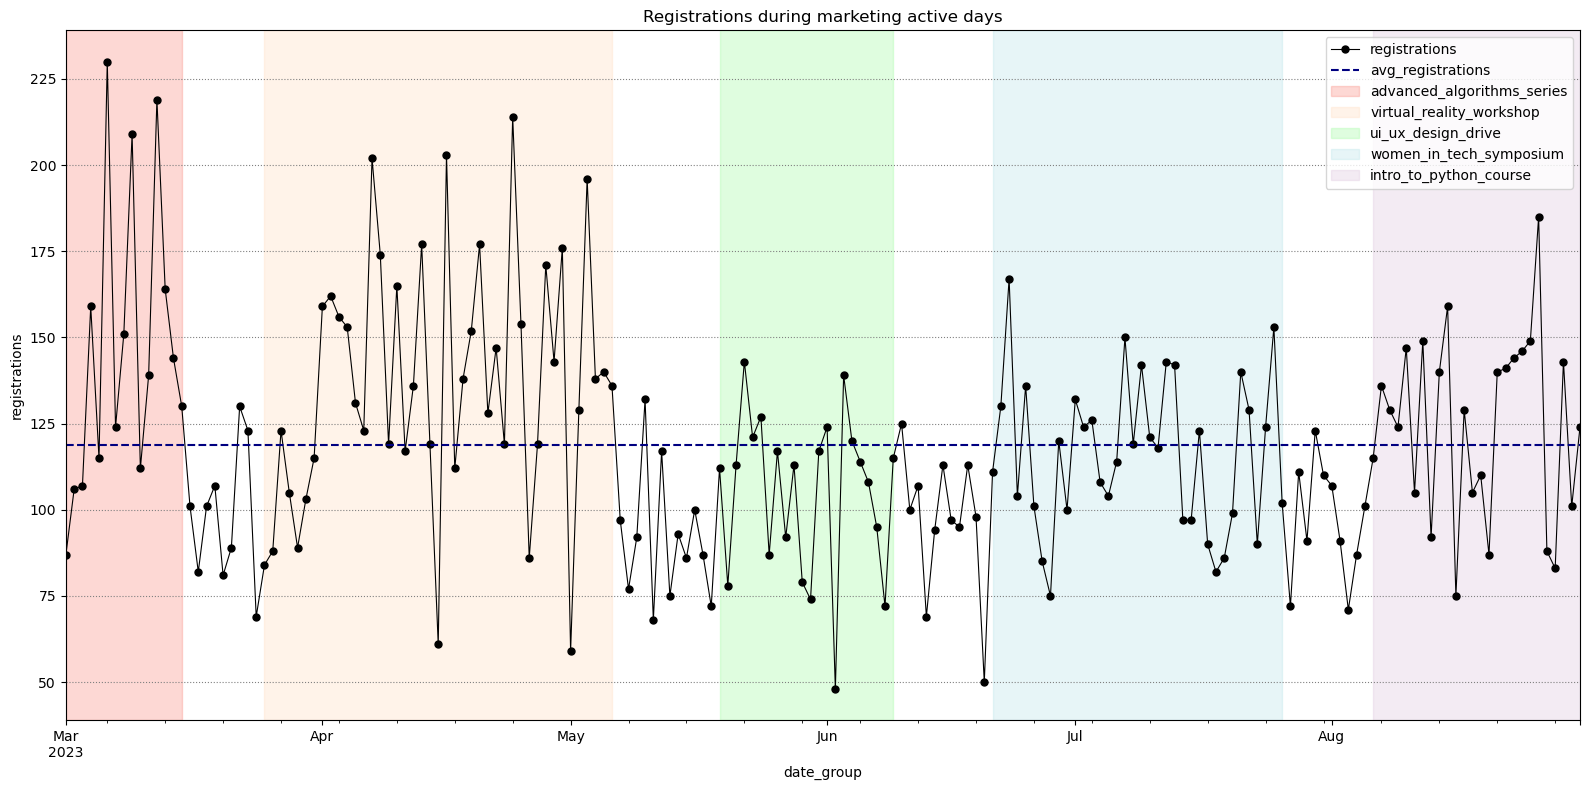

In [25]:
registrations_color = final_result.copy()
registrations_color['date_group'] = pd.to_datetime(registrations_color['date_group'])

# Создаем колонку с номерами кампаний
registrations_color['campaigns_n'] = (registrations_color['utm_campaign'] != registrations_color['utm_campaign'].shift()).cumsum()

# Фильтруем данные, исключая строки с 'none'
campaign_periods = (registrations_color
                    .dropna(subset=['utm_campaign'])
                    .loc[registrations_color['utm_campaign'] != 'none']  # Исключаем 'none'
                    .groupby(['campaigns_n','utm_campaign'])
                    .agg(start=('date_group', 'min'), finish=('date_group', 'max'))
                    .reset_index()
                   )

# Строим график
registrations_color.plot(x='date_group', y='registrations', kind='line', figsize=(16, 8), 
                  linewidth=0.8, color='black', label='registrations', marker='o', markersize=5)
plt.axhline(registrations_color['registrations'].mean(), linestyle='--', color='navy', label='avg_registrations')

# Добавляем цветные области для каждой рекламной кампании
colors = ['salmon', 'peachpuff', 'palegreen', 'powderblue', 'thistle']
for i, row in campaign_periods.iterrows():
    plt.axvspan(row['start'], row['finish'], color=colors[i % len(colors)], alpha=0.3, label=row['utm_campaign'])

# Оформление графика
plt.grid(axis='y', linestyle=':', color='grey')
plt.legend(loc='best')
plt.title('Registrations during marketing active days')
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.tight_layout()
plt.savefig('./charts/registrations_during_campaigns.png')
plt.show()

### Зависимость посещений от рекламы

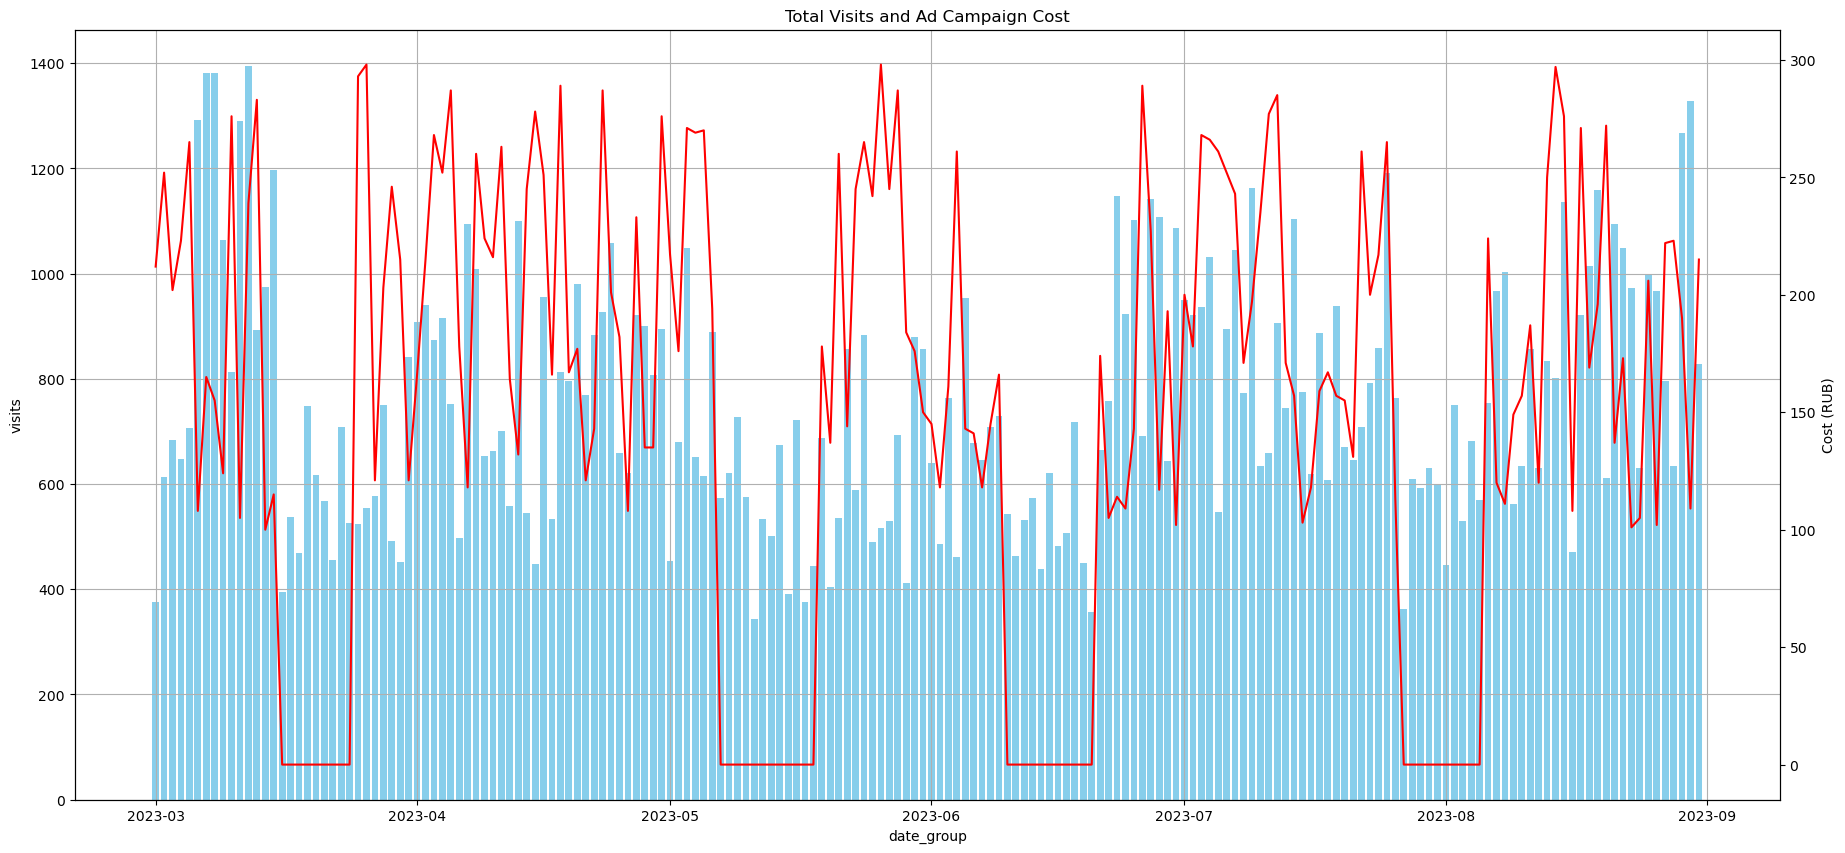

In [26]:
final_result['date_group'] = pd.to_datetime(final_result['date_group'])
fig, ax1 = plt.subplots(figsize=(22, 10))

ax1.bar(final_result['date_group'], final_result['visits'], label='Total Visits', color='skyblue')
ax1.set_xlabel('date_group')
ax1.set_ylabel('visits')
ax1.tick_params(axis='y')
ax1.set_title('Total Visits and Ad Campaign Cost')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(final_result['date_group'], final_result['cost'], color='red', label='Ad Campaign Cost')
ax2.set_ylabel('Cost (RUB)')
ax2.tick_params(axis='y')
plt.savefig('./charts/total_visits_and_ad_campaign_cost.png')
plt.show()

### Зависимость регистраций от рекламы

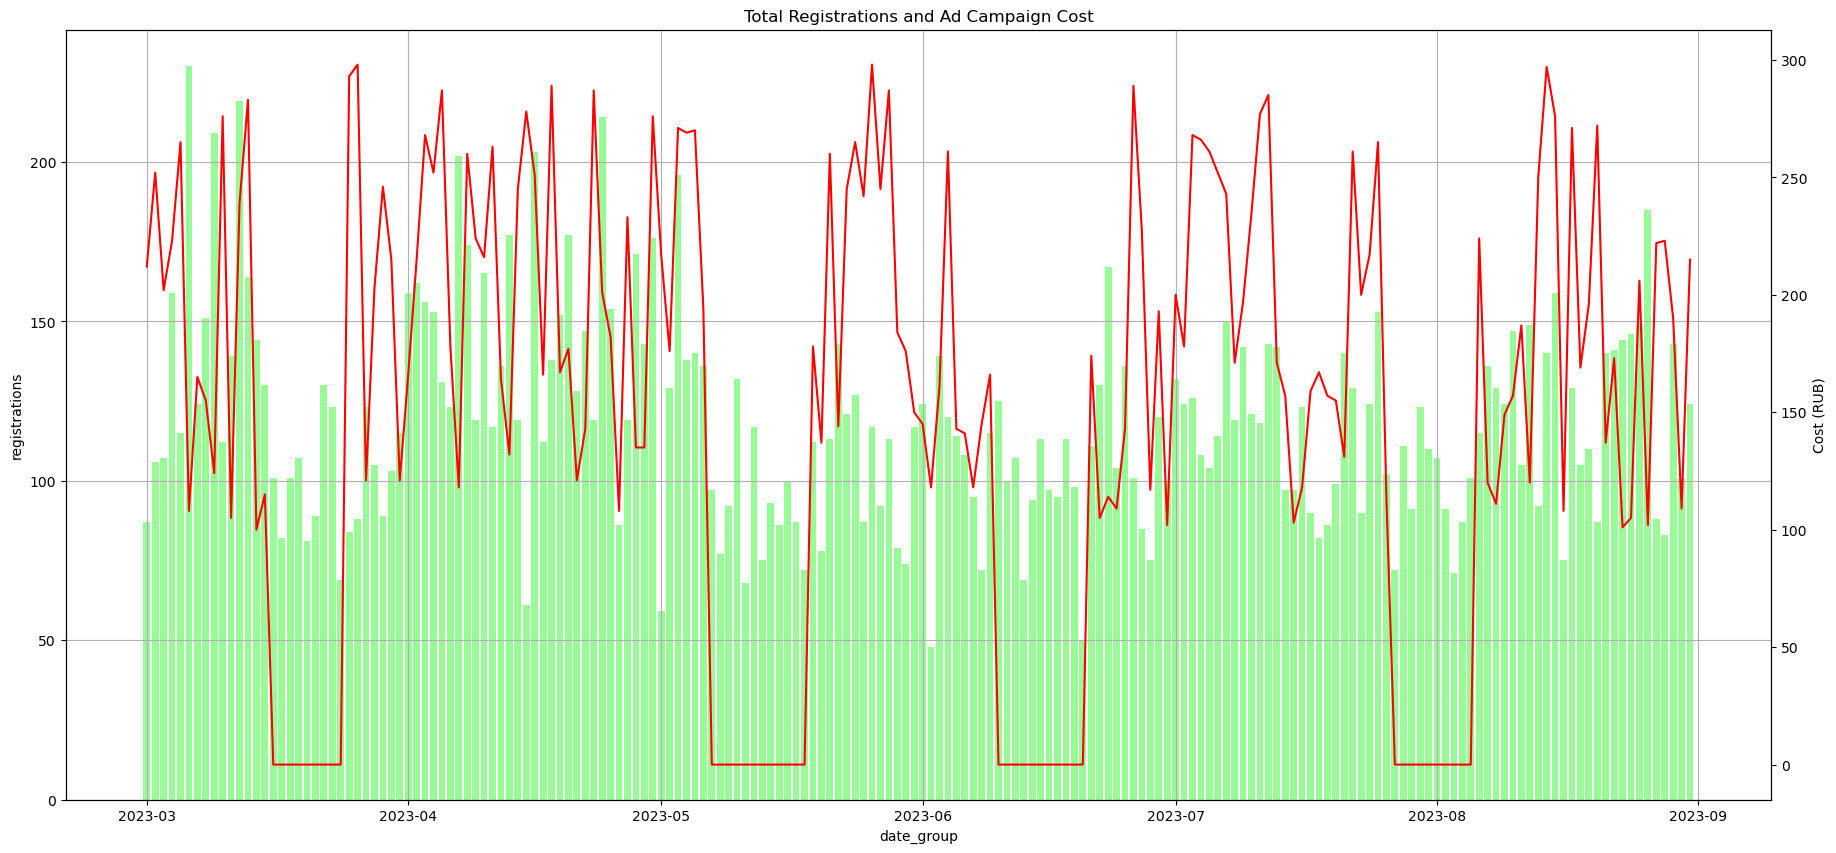

In [27]:
final_result['date_group'] = pd.to_datetime(final_result['date_group'])
fig, ax1 = plt.subplots(figsize=(22, 10))

ax1.bar(final_result['date_group'], final_result['registrations'], label='Total Registrations', color='palegreen')
ax1.set_xlabel('date_group')
ax1.set_ylabel('registrations')
ax1.tick_params(axis='y')
ax1.set_title('Total Registrations and Ad Campaign Cost')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(final_result['date_group'], final_result['cost'], color='red', label='Ad Campaign Cost')
ax2.set_ylabel('Cost (RUB)')
ax2.tick_params(axis='y')
plt.savefig('./charts/total_registrations_and_ad_campaign_cost.png')
plt.show()

### Зависимость конверсий от расходов на рекламу

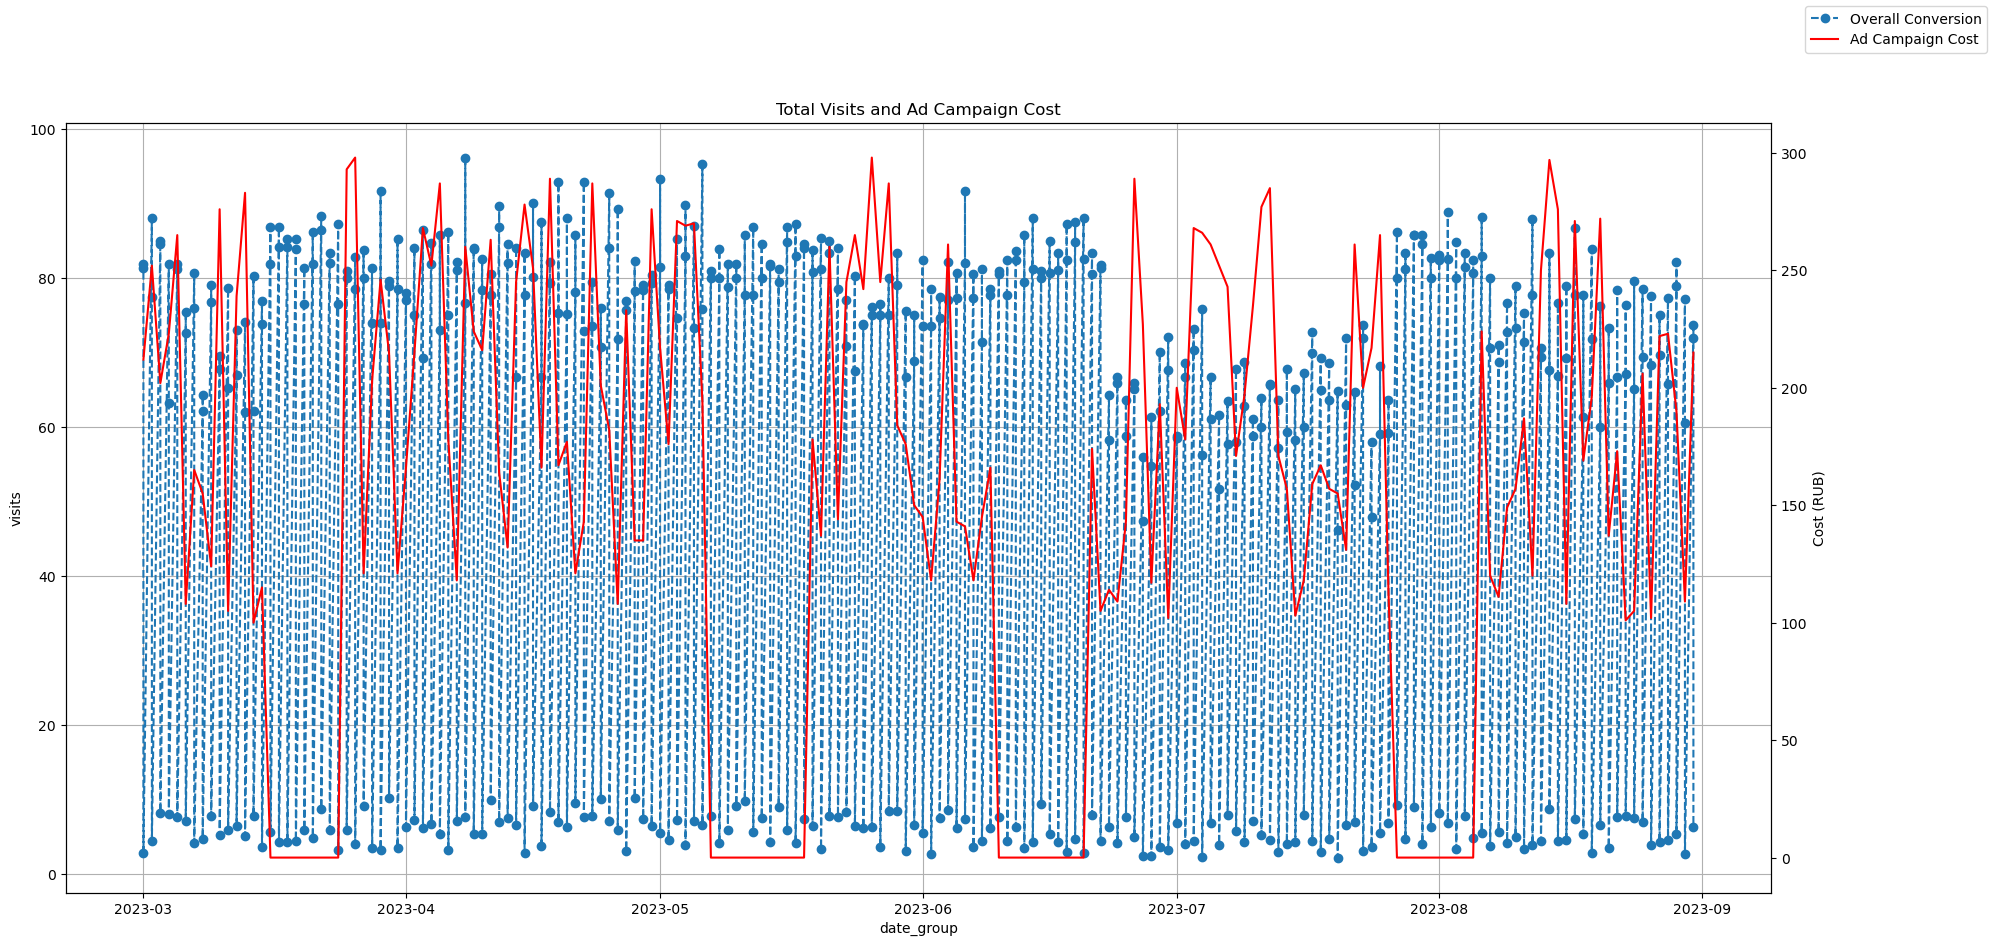

In [28]:
final_result['date_group'] = pd.to_datetime(final_result['date_group'])
fig, ax1 = plt.subplots(figsize=(22, 10))

ax1.plot(conversion_data['date_group'], conversion_data['conversion'], marker='o', linestyle='dashed', label='Overall Conversion')
ax1.set_xlabel('date_group')
ax1.set_ylabel('visits')
ax1.tick_params(axis='y')
ax1.set_title('Total Visits and Ad Campaign Cost')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(final_result['date_group'], final_result['cost'], color='red', label='Ad Campaign Cost')
ax2.set_ylabel('Cost (RUB)')
ax2.tick_params(axis='y')
fig.legend()
plt.savefig('./charts/overall_conversion_and_ad_campaign_cost.png')
plt.show()